In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# 从零开始的 NLP：用字符级 RNN 生成名称
**作者**：[Sean Robertson](https://github.com/spro)

这是我们“从零开始的 NLP”三部曲教程中的第二篇。在[第一篇教程](/intermediate/char_rnn_classification_tutorial)中，我们使用了 RNN 来将名字分类到它们的原始语言。这次我们将反其道而行之，从语言生成名字。

```sh
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```
我们仍然在手工制作一个带有几个线性层的小型 RNN。最大的区别在于，我们不是在读入一个名字的所有字母后预测一个类别，而是输入一个类别并一次输出一个字母。循环预测字符以形成语言（这也可以用单词或其他更高阶的结构来完成）通常被称为“语言模型”。

**推荐阅读：**

我假设你至少已经安装了 PyTorch，了解 Python，并且理解了张量：

-  https://pytorch.org/ 有关安装说明
-  :doc:`/beginner/deep_learning_60min_blitz` 开始了解 PyTorch 的基础
-  :doc:`/beginner/pytorch_with_examples` 对 PyTorch 有一个广泛而深入的概述
-  :doc:`/beginner/former_torchies_tutorial` 如果你是 Lua Torch 的前用户

了解 RNN 及其工作原理也会很有帮助：

-  [循环神经网络的不合理效应](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   展示了一些现实生活中的例子
-  [理解 LSTM 网络](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   主要是关于 LSTM，但也对了解 RNN 通常很有帮助

我还建议阅读前面的教程，:doc:`/intermediate/char_rnn_classification_tutorial`


## 准备数据

<div class="alert alert-info"><h4>注意</h4><p>从
   [这里](https://download.pytorch.org/tutorial/data.zip)
   下载数据，并将其解压到当前目录。</p></div>

有关此过程的更多细节，请参见上一个教程。简而言之，有许多纯文本文件 ``data/names/[Language].txt``，每行有一个名字。我们将行分割成数组，将 Unicode 转换为 ASCII，最终得到一个字典 ``{language: [names ...]}``。

In [1]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('../../data/nlp_scratch/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Dutch', 'Russian', 'Scottish', 'Arabic', 'Vietnamese', 'German', 'Chinese', 'Italian', 'Polish', 'English', 'Czech', 'Korean', 'Irish', 'Spanish', 'Japanese', 'Portuguese', 'French', 'Greek']
O'Neal


## 创建网络

这个网络扩展了[上一个教程的 RNN](#Creating-the-Network)_，增加了一个额外的类别张量参数，该参数与其他张量一起连接。类别张量是一个one-hot vector，就像字母输入一样。

我们将输出解释为下一个字母的概率。在抽样时，最有可能的输出字母被用作下一个输入字母。

我添加了第二个线性层 ``o2o``（在合并隐藏层和输出层之后），以提供更强大的处理能力。还有一个 dropout 层，它[随机将其输入的部分变为零](https://arxiv.org/abs/1207.0580)_，给定概率（这里是 0.1），通常用于模糊输入以防止过拟合。在这里，我们在网络的末端使用它，故意增加一些混乱并增加抽样的多样性。

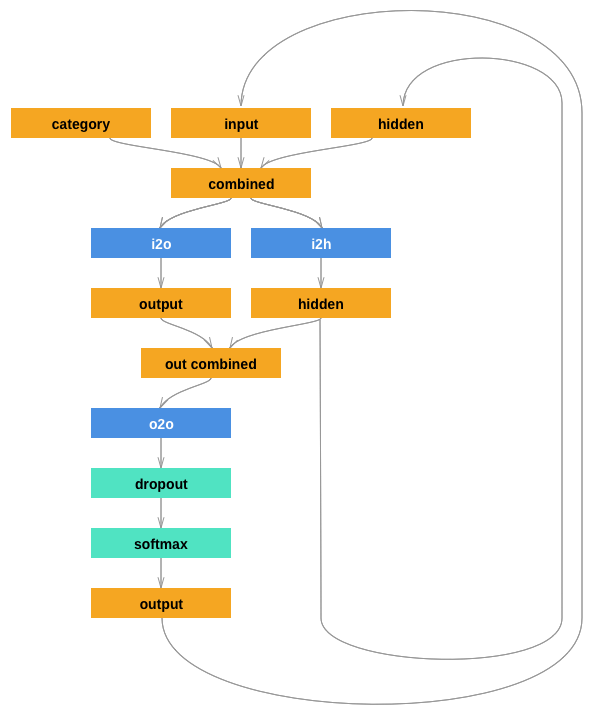




In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 训练
准备训练
----------------------

首先，使用一个帮助函数来随机获取(category, line)对：




In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

对于每个时间步（即训练单词中的每个字母），网络的输入将是``(category, current letter, hidden state)``，输出将是``(next letter, next hidden state)``。因此，对于每个训练集，我们将需要类别、一组输入字母和一组输出/目标字母。

由于我们在每个时间步都是从当前字母预测下一个字母，所以字母对是行中连续字母的组合 - 例如，对于``"ABCD<EOS>"``，我们会创建("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS")。

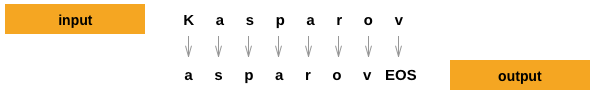

类别张量是大小为``<1 x n_categories>``的[one hot vector](https://en.wikipedia.org/wiki/One-hot)_。在训练时，我们在每个时间步将其输入网络 - 这是一个设计选择，它本可以作为初始隐藏状态的一部分或采用其他策略。

In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

为了在训练时方便，我们会创建一个``randomTrainingExample``函数来随机获取(category, line)对，并且把他们转换成需要的(category, input, target)张量


In [5]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 训练网络

与分类不同，在分类中只使用最后的输出，而在这里，我们在每一步都进行预测，因此我们在每一步都计算损失。

自动微分（autograd）的神奇之处在于，你可以简单地在每一步将这些损失相加，并在最后调用反向传播（backward）。


In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

为了记住训练的时间，我们加上``timeSince(timestamp)``函数，它会返回一个人类可读的字符串：


In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

训练像往常一样进行 - 多次调用训练函数并等待几分钟，在每``print_every``个示例打印当前时间和损失，并在``all_losses``中存储每``plot_every``个示例的平均损失，以便稍后绘图。


In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 4.4524
0m 9s (10000 10%) 2.5784
0m 13s (15000 15%) 2.1352
0m 18s (20000 20%) 3.1675
0m 23s (25000 25%) 3.7612
0m 27s (30000 30%) 2.8257
0m 32s (35000 35%) 2.5575
0m 36s (40000 40%) 2.5247
0m 41s (45000 45%) 1.5731
0m 46s (50000 50%) 2.1229
0m 50s (55000 55%) 2.4777
0m 55s (60000 60%) 2.3516
0m 59s (65000 65%) 2.1016
1m 4s (70000 70%) 2.7440
1m 8s (75000 75%) 2.4753
1m 13s (80000 80%) 2.8142
1m 17s (85000 85%) 3.3145
1m 22s (90000 90%) 2.5471
1m 26s (95000 95%) 2.4219
1m 31s (100000 100%) 2.8564


### 绘制损失

Plotting the historical loss from all\_losses shows the network learning:




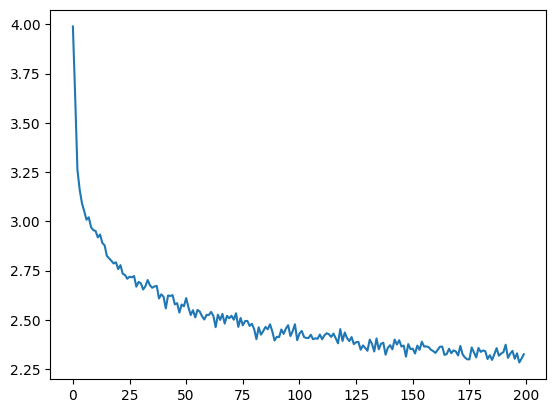

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 抽样网络

为了进行抽样，我们给网络一个字母并询问下一个是什么，将其作为下一个字母输入，并重复这个过程直到出现 EOS（句子结束）标记。

-  为输入类别、起始字母和空的隐藏状态创建张量
-  创建一个以起始字母为开头的字符串 ``output_name``
-  直到达到最大输出长度，

   -  将当前字母输入到网络
   -  从最高输出中获取下一个字母和下一个隐藏状态
   -  如果字母是 EOS，则停止
   -  如果是常规字母，加入到 ``output_name`` 并继续

-  返回最终的名字

<div class="alert alert-info"><h4>注意</h4><p>另一种策略是，在训练中包含一个“字符串开始”标记，而不是必须给它一个起始字母，并让网络选择自己的起始字母。</p></div>



In [10]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovekov
Uakinov
Sakilan
Ganter
Eren
Rour
Santa
Para
Allon
Chin
Han
Iu


## Exercises

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


